In [26]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed

%matplotlib widget

rng = np.random.default_rng(125)

In [27]:
# 2D design matrix
# omit y for a 1D design matrix
def DesignMatrix(p_order: int, x: npt.ArrayLike, y: npt.ArrayLike = None, intercept: bool = True) -> npt.NDArray:
    """
    Produce a Design matrix for linear regression for a given polynomial order in 1d or omit y for 2d

    Parameters:
        p_order (int): Order of polynomial
        x (ArrayLike): Array to be used in the Design matrix
        y (ArrayLike, optional): Add this parameter for 2d Design matrix, leave empty for 1d
        intercept (bool, optional): Wether the intercept should be included in the Design matrix, if False remove the first parameter
    """
    n = np.sum(range(p_order+2))
    
    if y.any() != None:
        X = np.ones((len(x), 1))
        for k in range(1, p_order+1):
            j = k
            i = 0
            while i < k + 1:
                X = np.column_stack((X, x**i*y**j))
                # if i == j:
                #     X = np.column_stack((X, x**i*y**j))
                # else:
                #     X = np.column_stack((X, x**i*y**j))
                #     X = np.column_stack((X, y**i*x**j))
                j -= 1
                i += 1
    
    else:
        X = np.ones((len(x), p_order+1))
        for i in range(1, p_order+1):
            X[:,i] = x**i

    if not intercept:
        X = np.delete(X, 0, 1)

    return X
    # 1                     #1
    # x,y                   #2
    # x²,y²,xy              #3
    # x³,y³,yx²,xy²         #4
    # x⁴,y⁴,yx³,xy³,x²y²    #5
    
    # 1,
    # 2, 2
    # 4, 4, 4
    # 8, 8, 8, 8
    # 16, 16, 16, 16, 16


def FrankeFunction(x: npt.ArrayLike, y: npt.ArrayLike, noise: bool=False) -> npt.NDArray:
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4 + int(noise)*rng.normal(0, 0.1, x.shape)


def R2(y_data: npt.ArrayLike, y_model: npt.ArrayLike) -> float:
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)


def MSE(y_data: npt.ArrayLike,y_model: npt.ArrayLike) -> float:
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

In [28]:
x = np.array([2])
y = np.array([2])
DesignMatrix(5, x, y)

array([[ 1.,  2.,  2.,  4.,  4.,  4.,  8.,  8.,  8.,  8., 16., 16., 16.,
        16., 16., 32., 32., 32., 32., 32., 32.]])

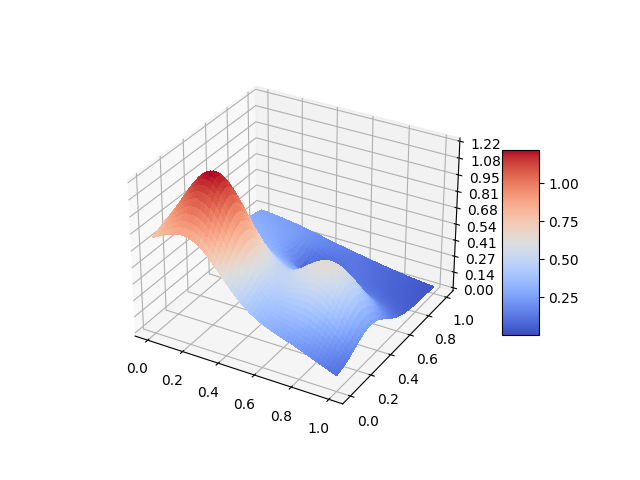

In [29]:
fig, ax = plt.subplots(subplot_kw={"projection" : "3d"})

n = 100
# Make data.
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
x, y = np.meshgrid(x,y)

z = FrankeFunction(x, y, False)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

## Ordinary Linear Square Regression

In [30]:
n = 100
# Make data.
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)

X = DesignMatrix(5, x, y)

x, y = np.meshgrid(x, y)
z = FrankeFunction(x, y, noise=False)

X_train, X_test, y_train, y_test = train_test_split(X, z, test_size=0.2, random_state=125)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler.fit(y_train)
y_train_scaled = scaler.transform(y_train)
y_test_scaled = scaler.transform(y_test)


beta = (np.linalg.pinv(X_train.T @ X_train) @ X_train.T ) @ y_train
print('Unscaled data')
y_fit = X_train @ beta
print(f'Training fit:\n   MSE = {MSE(y_train, y_fit)} ; R2 = {R2(y_train, y_fit)}')

y_pred = X_test @ beta
print(f'Test fit:\n   MSE = {MSE(y_test, y_pred)} ; R2 = {R2(y_test, y_pred)}')

beta_scaled = (np.linalg.pinv(X_train_scaled.T @ X_train_scaled) @ X_train_scaled.T ) @ y_train_scaled
print('\nScaled data')
y_fit_scaled = X_train_scaled @ beta_scaled
print(f'Training fit:\n   MSE = {MSE(y_train_scaled, y_fit_scaled)} ; R2 = {R2(y_train_scaled, y_fit_scaled)}')

y_pred_scaled = X_test_scaled @ beta_scaled
print(f'Test fit:\n   MSE = {MSE(y_test_scaled, y_pred_scaled)} ; R2 = {R2(y_test_scaled, y_pred_scaled)}')

Unscaled data
Training fit:
   MSE = 0.00034740921533360833 ; R2 = 0.9959637706799658
Test fit:
   MSE = 0.0006713272819340129 ; R2 = 0.9895554009536764

Scaled data
Training fit:
   MSE = 0.005319309294809085 ; R2 = 0.9946806907051909
Test fit:
   MSE = 0.012149092010587646 ; R2 = 0.9849946574091957


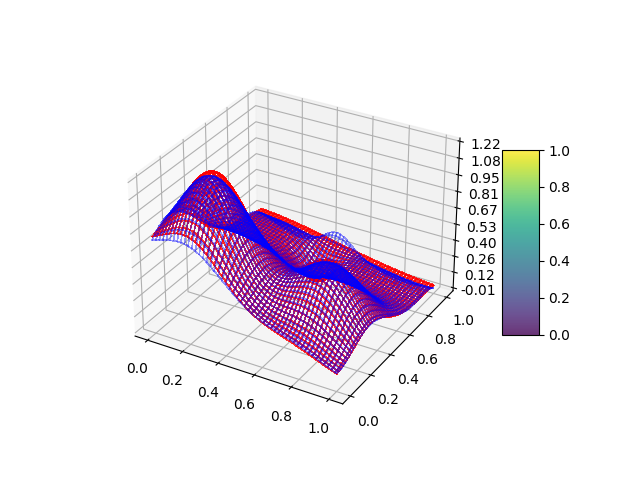

In [31]:
fig, ax = plt.subplots(subplot_kw={"projection" : "3d"})

# Plot the surface.
ax.plot_wireframe(x, y, X @ beta, colors='blue',
                       linewidth=0.4, antialiased=False, alpha=0.4)
surf = ax.plot_wireframe(x, y, z, colors='red',
                       linewidth=0.4, antialiased=False, alpha=0.8)

# Customize the z axis.
#ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

## Ridge Regression

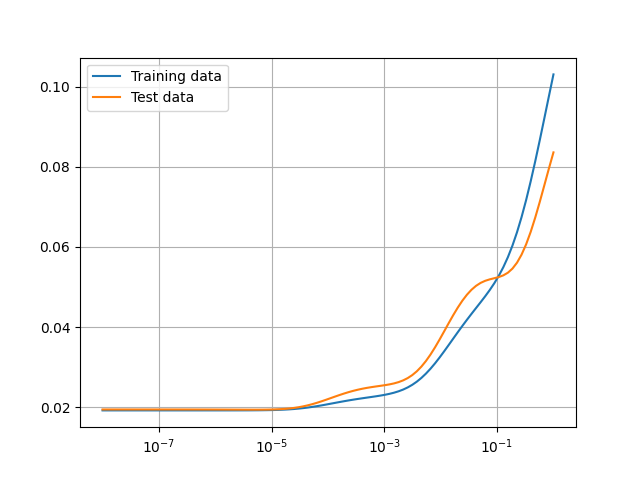

In [32]:
n = 100
# Make data.
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)

X = DesignMatrix(5, x, y, intercept=False)

x, y = np.meshgrid(x, y)
z = FrankeFunction(x, y, noise=True)

p = X.shape[1]
I = np.eye(p, p)
lambdas = np.logspace(-8, 0, n)

X_train, X_test, y_train, y_test = train_test_split(X, z, test_size=0.2, random_state=125)

MSE_train = []
MSE_test = []
for lmb in lambdas:
    beta = np.linalg.pinv(X_train.T @ X_train + lmb*I) @ X_train.T @ y_train
    y_fit = X_train @ beta
    y_pred = X_test @ beta

    MSE_train.append(MSE(y_train, y_fit))
    MSE_test.append(MSE(y_test, y_pred))

    # print(f'Training fit:\n   MSE = {MSE(y_train, y_fit)} ; R2 = {R2(y_train, y_fit)}')
    # print(f'Test fit:\n   MSE = {MSE(y_test, y_pred)} ; R2 = {R2(y_test, y_pred)}')

plt.figure()

plt.plot(lambdas, MSE_train, label='Training data')
plt.plot(lambdas, MSE_test, label='Test data')
plt.xscale('log')
plt.grid()
plt.legend()

plt.show()

## Lasso Regression

/home/lars/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.982e+00, tolerance: 2.954e-03
  model = cd_fast.enet_coordinate_descent(
/home/lars/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.184e+00, tolerance: 2.938e-03
  model = cd_fast.enet_coordinate_descent(
/home/lars/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.131e+

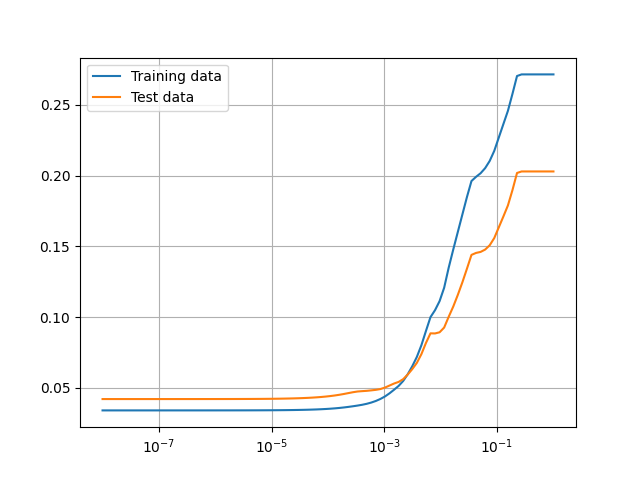

In [33]:
n = 100
# Make data.
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)

X = DesignMatrix(5, x, y, intercept=False)

x, y = np.meshgrid(x, y)
z = FrankeFunction(x, y, noise=True)

p = X.shape[1]
I = np.eye(p, p)
lambdas = np.logspace(-8, 0, n)

X_train, X_test, y_train, y_test = train_test_split(X, z, test_size=0.2, random_state=125)

MSE_train = []
MSE_test = []
for lmb in lambdas:
    reg = linear_model.Lasso(lmb, fit_intercept=False)
    reg.fit(X_train, y_train)

    y_fit = reg.predict(X_train)
    y_pred = reg.predict(X_test)

    MSE_train.append(MSE(y_train, y_fit))
    MSE_test.append(MSE(y_test, y_pred))

    # print(f'Training fit:\n   MSE = {MSE(y_train, y_fit)} ; R2 = {R2(y_train, y_fit)}')
    # print(f'Test fit:\n   MSE = {MSE(y_test, y_pred)} ; R2 = {R2(y_test, y_pred)}')

plt.figure()

plt.plot(lambdas, MSE_train, label='Training data')
plt.plot(lambdas, MSE_test, label='Test data')
plt.xscale('log')
plt.grid()
plt.legend()

plt.show()

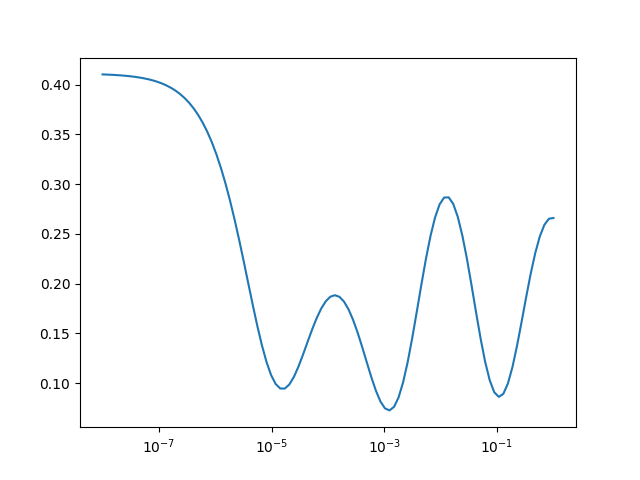

In [59]:
n = 100
# Make data.
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)

X = DesignMatrix(5, x, y, intercept=False)

x, y = np.meshgrid(x, y)
z = FrankeFunction(x, y, noise=True)

p = X.shape[1]
I = np.eye(p, p)
lambdas = np.logspace(-8, 0, n)

X_train, X_test, y_train, y_test = train_test_split(X, z, test_size=0.2, random_state=125)

k = 5
model = make_pipeline(
    StandardScaler(),
    linear_model.LinearRegression(),
    linear_model.Ridge(fit_intercept=False),
    linear_model.Lasso(fit_intercept=False),
    KFold(n_splits=k),
)

mse = []
for lmb in lambdas:
    ridge = model.named_steps['ridge'].set_params(alpha=lmb)
    k_fold = model.named_steps['kfold']
        
    cv = cross_val_score(ridge, X, z, scoring='neg_mean_squared_error', cv=k_fold)
    mse.append(np.mean(-cv))
    
plt.figure()

plt.plot(lambdas, mse)
plt.xscale('log')

plt.show()